## TO DO LIST

* Nodes samen nemen
* Kortste route bepalen (inclusief wachttijd en overstaptijd)
* Andere prioriteiten: minste wachttijd en minste overstappen
* Voertuig logging verbeteren
* Overstap mogelijk maken
* Voertuig moet de juiste mensen meenemen

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data

In [2]:
# Import stations and lines from excel sheets
df1 = pd.read_csv("../../stations.csv")
df2 = pd.read_csv("../../lijnen.csv")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x))

In [3]:
df1 = df1.drop([2, 3, 4, 5])
df1

,Unnamed: 0,HalteNaam,HalteLat,HalteLon,Capacity,Line
0,0,Noord,52.401172,4.931232,100,metro52
1,1,Noorderpark,52.388555,4.917891,100,metro52
6,6,Europaplein,52.341855,4.891384,100,metro52
7,7,Zuid,52.339080,4.875099,100,metro52
8,8,CentraalStation,52.377720,4.901043,100,tram24
9,9,Dam,52.374929,4.895494,100,tram24
10,10,Rokin,52.369855,4.892305,100,tram24
11,11,Muntplein,52.366462,4.893238,100,tram24
12,12,Vijzelgracht,52.360297,4.891120,100,tram24
13,13,MarieHeinekenplein,52.357221,4.890772,100,tram24


In [4]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [5]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

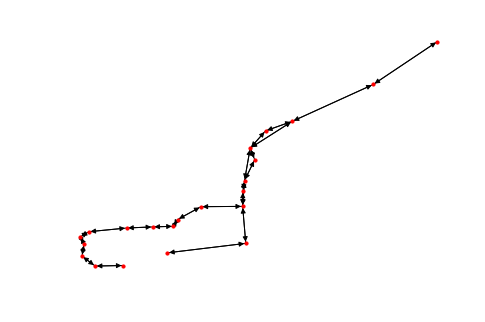

In [6]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

In [7]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["duration"] += (route_info["transfers"] * 2)
    return route_info

### Create moving parts

In [8]:
def generate_passenger(origin, destination, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination, weight = 'duration')
    
    transfers = 1
    
    route_info = route_calculation(route, environment.FG)
    
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy()
                        })

In [9]:
def generate_metro(line, environment, linename):
    """ Generate a metro """
    Metro = type('Metro', (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})

    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Metro(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

### Spawn the metro trains

In [10]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        metro = generate_metro(lines[name][x], env, name)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every X minutes
        yield env.timeout(frequency * 60)

In [11]:
def passengers(env):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, env)
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for metro start", env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)

        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 30)

### Run simulation

In [12]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.metros = []
env.passengers = []

# Start the simulation
env.process(vehicle(env, 5.5, 6, "metro52", 0))
env.process(vehicle(env, 5.585, 6, "metro52", 1))
env.process(vehicle(env, 6, 10, "tram24", 0))
env.process(vehicle(env, 6, 10, "tram24", 1))
env.process(passengers(env))
env.run(until = env.now + 1 * 24 * 60 * 60)

### Check results

In [13]:
env.metros[17].log

{'Message': ['Loading start',
  'Loading stop',
  'Sailing from node Zuid to node Europaplein start',
  'Sailing from node Zuid to node Europaplein stop',
  'Loading start',
  'Loading stop',
  'Sailing from node Europaplein to node DePijp start',
  'Sailing from node Europaplein to node DePijp stop',
  'Sailing from node DePijp to node Vijzelgracht start',
  'Sailing from node DePijp to node Vijzelgracht stop',
  'Sailing from node Vijzelgracht to node Rokin start',
  'Sailing from node Vijzelgracht to node Rokin stop',
  'Sailing from node Rokin to node CentraalStation start',
  'Sailing from node Rokin to node CentraalStation stop',
  'Sailing from node CentraalStation to node Noorderpark start',
  'Sailing from node CentraalStation to node Noorderpark stop',
  'Sailing from node Noorderpark to node Noord start',
  'Sailing from node Noorderpark to node Noord stop'],
 'Timestamp': [datetime.datetime(2019, 1, 1, 6, 11, 6),
  datetime.datetime(2019, 1, 1, 6, 11, 6),
  datetime.datetim

In [14]:
loglist = []
passengerlist = []
for i in range(len(env.passengers)):
    if ['Waiting for metro start','Waiting for metro stop','In metro start'] == env.passengers[i].log['Message']:
        passengerlist.append(env.passengers[i])
    loglist.append(env.passengers[i].log['Message'])
    
print(len(loglist))
print(loglist.count(['Waiting for metro start']))
print(loglist.count(['Waiting for metro start','Waiting for metro stop','In metro start']))
print(loglist.count(['Waiting for metro start','Waiting for metro stop','In metro start', 'In metro stop']))

4483
21
4462
0


In [15]:
env.passengers[1].__dict__

{'env': <simpy.core.Environment at 0xa1c581518>,
 'log': {'Message': ['Waiting for metro start',
   'Waiting for metro stop',
   'In metro start'],
  'Timestamp': [datetime.datetime(2019, 1, 1, 5, 30, 6, 781887),
   datetime.datetime(2019, 1, 1, 6, 14),
   datetime.datetime(2019, 1, 1, 6, 14)],
  'Value': [0, 0, 0],
  'Geometry': [<shapely.geometry.point.Point at 0xa10f8a9b0>,
   <shapely.geometry.point.Point at 0xa10f8a9b0>]},
 'route': ['Beethovenstraat',
  'GerritvdVeenstraat',
  'RoelofHartplein',
  'DePijp',
  'Vijzelgracht',
  'Muntplein'],
 'complete_path': None,
 'route_info': {'lines': ['tram24', 'metro52', 'tram24'],
  'duration': 15,
  'transfers': 2,
  'transferstations': ['DePijp', 'Vijzelgracht']},
 'transfers': 2,
 'transferstations': ['DePijp', 'Vijzelgracht'],
 'duration': 15,
 'lines': ['tram24', 'metro52', 'tram24'],
 'name': 'Passenger',
 'id': '7a6735e8-70d6-11e9-9e56-7831c1d08f6a'}

In [16]:
passengers = []
for i in range(len(env.passengers)):
    if env.passengers[i].route[0] == 'CentraalStation' and env.passengers[i].route[-1] == "Vijzelgracht":
        passengers.append(env.passengers[i])

In [17]:
pd.DataFrame.from_dict(env.passengers[1].log)

,Message,Timestamp,Value,Geometry
0,Waiting for metro start,2019-01-01 05:30:06.781887,0,POINT (52.34686888 4.87632951)
1,Waiting for metro stop,2019-01-01 06:14:00.000000,0,POINT (52.34686888 4.87632951)
2,In metro start,2019-01-01 06:14:00.000000,0,POINT (52.34686888 4.87632951)


In [18]:
print(FG.node['Noorderpark']['geometry'])

POINT (52.38855518 4.91789115)


In [19]:
pd.DataFrame.from_dict(env.metros[18].log)

,Message,Timestamp,Value,Geometry
0,Loading start,2019-01-01 06:12:00,0,POINT (52.40117202 4.93123182)
1,Loading stop,2019-01-01 06:12:00,30,POINT (52.40117202 4.93123182)
2,Sailing from node Noord to node Noorderpark start,2019-01-01 06:12:00,0,POINT (52.40117202 4.93123182)
3,Sailing from node Noord to node Noorderpark stop,2019-01-01 06:14:00,0,POINT (52.38855518 4.91789115)
4,Loading start,2019-01-01 06:14:15,0,POINT (52.38855518 4.91789115)
5,Loading stop,2019-01-01 06:14:15,30,POINT (52.38855518 4.91789115)
6,Sailing from node Noorderpark to node Centraal...,2019-01-01 06:14:15,0,POINT (52.38855518 4.91789115)
7,Sailing from node Noorderpark to node Centraal...,2019-01-01 06:16:15,0,POINT (52.37771998 4.90104337)
8,Loading start,2019-01-01 06:16:30,0,POINT (52.37771998 4.90104337)
9,Loading stop,2019-01-01 06:16:30,30,POINT (52.37771998 4.90104337)


In [20]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
        passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route, 
                                        "origin": env.passengers[i].route[0], 
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": 0, 
                                        "waiting_time": 0, 
                                        "modes": 0, 
                                        "transferindex": 0, 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "class": 0, 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("../../passengers.csv", index=True)

In [21]:
vehicledict = {}

for i in range(len(env.metros)):
    try:
        vehicledict[env.metros[i].id] = {"route": env.metros[i].route, 
                                        "mode": env.metros[i].name, 
                                        "departure": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("../../vehicles.csv", index=True)